In [1]:
import warnings
import numpy as np 
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder

# Pima Indians Diabetes Study

Source: https://www.kaggle.com/uciml/pima-indians-diabetes-database

Pipeline of a machine learning study:

- loading data
- describing data, discrete/continuous, categorical/not categorical
- data cleaning (eliminating NaNs), converting text data to numeric values, removing duplicate rows
- basic distributions of features, correlation matrix
- data analysis with diagrams:
    - histograms
    - paired histograms
    - ratio for categorical data: pie chart
    - analysis along at least two dimensions: scatter plot
    - box plots

- data normalization
- training machine learning models
- evaluation of the results:
    - accuracy, confusion matrix in more dimension
    - ROCAUC curve
    - PPV, NPV (positive predictive value, in binary classification)

<b> At each step, describe the current step with comment block (Markdown cell in Jupyter). While examining the data, try to come up with assumptions. In this notebook there some examples for that, these are for presentation purposes only, not medical facts </b>

In [ ]:
data_path = "./data/diabetes.csv"

In [3]:
warnings.simplefilter(action='ignore')
df = pd.read_csv(data_path)
# Define columns with 0 values (NaN) 
null_cols = ["Age", "Insulin","BloodPressure", "SkinThickness", "BMI"]
from sklearn.impute import SimpleImputer
# Fill nulls with the median of the column
median_imputer = SimpleImputer(strategy="median")
for col in null_cols:
    median=df[col].median()
    df=df.replace({col : {0: median}})
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72.0,35.0,30.5,33.6,0.627,50,1
1,1,85,66.0,29.0,30.5,26.6,0.351,31,0
2,8,183,64.0,23.0,30.5,23.3,0.672,32,1
3,1,89,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137,40.0,35.0,168.0,43.1,2.288,33,1


# Variables

### Categorical

Outcome - is diabetes daignosed? (1-yes, 0-no)

### Not categorical


Glucose - Blood glucose concentration

Insulin - Blood insulin concentration

SkinThickness - Triceps skin fold thickness (in mm)

BMI - Body-mass index

BloodPressure - Diastolic blood pressure (mm Hg)

DiabetesPedigreeFunction - A function which scores likelihood of diabetes based on family history

Pregnancies - Number of times pregnant

Age

In [4]:
# eliminate NaN values and duplicates
print(df.shape)
total_nulls = df.isnull().sum()
total_observations = df.shape[0]
null_percentages = total_nulls[total_nulls > 0] / total_observations * 100
print(pd.concat([total_nulls, null_percentages], axis=1, keys=["Total", "Percentage"]).sort_values(by="Total", ascending=False))
duplicates_index = df[df.duplicated(keep="first")].index
# Check for duplicates and keep the first instance
df.drop(duplicates_index, axis=0, inplace=True)
# Check to confirm no duplicates
df[df.duplicated(keep="first")]
# Check the new shape of the data
print(df.shape)

(768, 9)
                          Total  Percentage
Pregnancies                   0         NaN
Glucose                       0         NaN
BloodPressure                 0         NaN
SkinThickness                 0         NaN
Insulin                       0         NaN
BMI                           0         NaN
DiabetesPedigreeFunction      0         NaN
Age                           0         NaN
Outcome                       0         NaN
(768, 9)


# Plot distributions

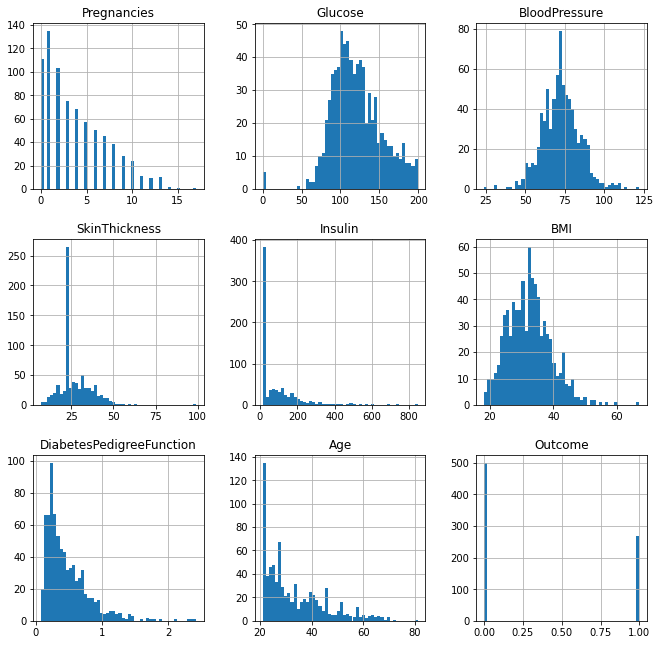

In [5]:
fig, ax = plt.subplots(figsize=(11, 11))
df.hist(bins=50, ax=ax)
plt.show()

# Correlation matrix

In this case the correlation matrix is applicable almost all cases, as the outcome is the only categorical feature. The strongest connection is between BMI and SkinThickness.

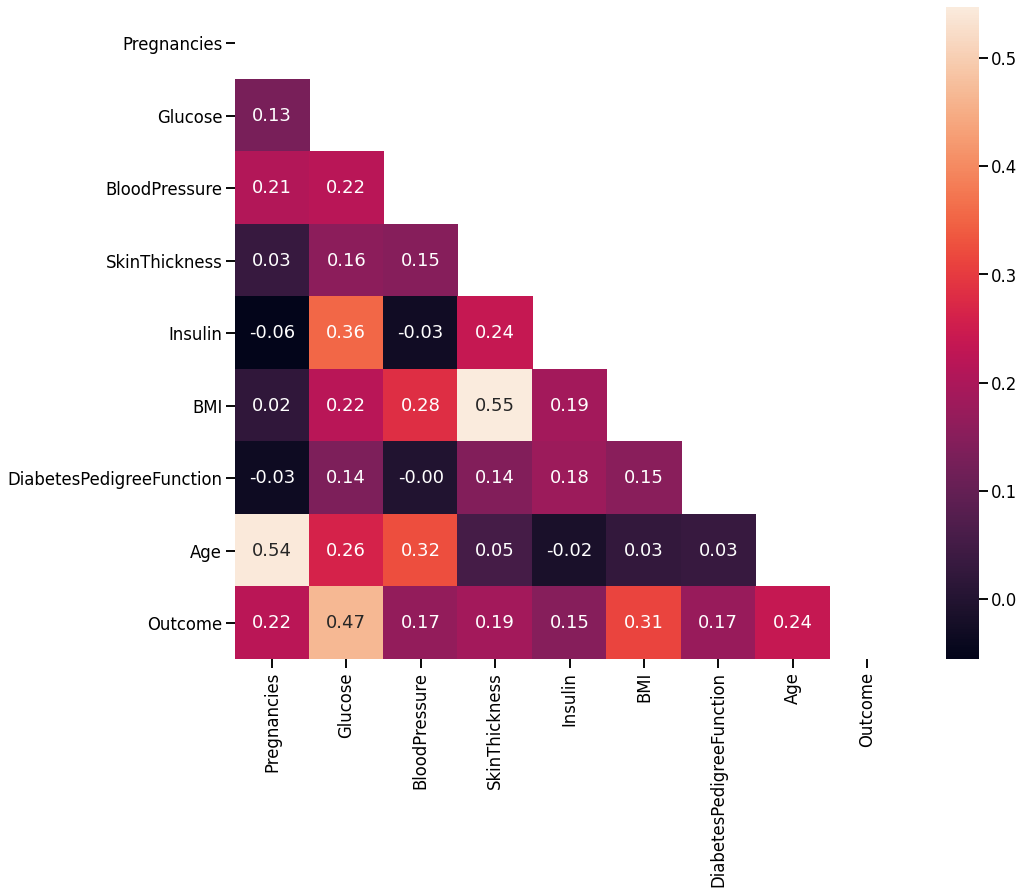

In [6]:
sns.set_context("talk")
plt.figure(figsize=(15, 12))
mask = np.triu(df.corr())
sns.heatmap(df.corr(), annot=True, fmt=".2f",mask=mask)
plt.show()

# Age distribution

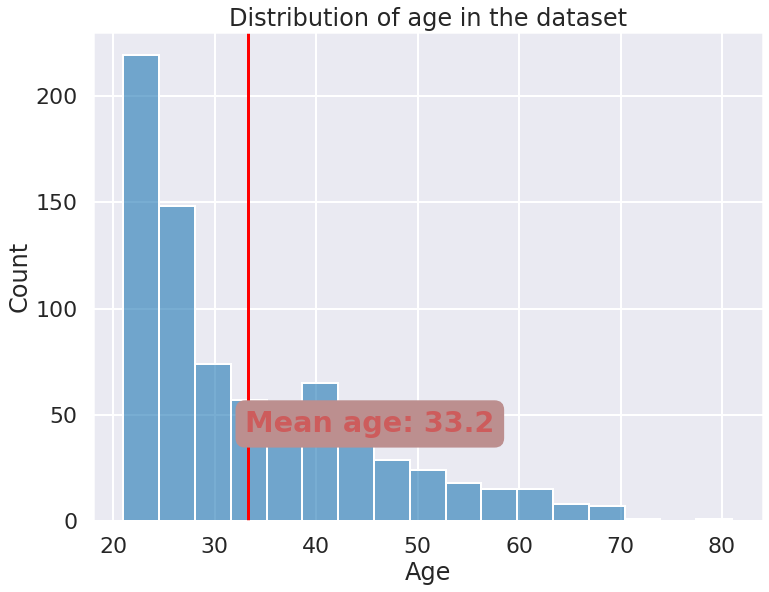

In [7]:
sns.set_style("darkgrid")
sns.set_context("poster")
plt.figure(figsize=(12, 9))
sns.histplot(data=df["Age"], alpha=0.6)
plt.axvline(df["Age"].mean(), color="red")
plt.title("Distribution of age in the dataset")
plt.text(33, 42, "Mean age: " + str(round(df["Age"].mean(), 1)), color="indianred", weight="heavy", size="larger", bbox=dict(boxstyle="round", color="rosybrown"))
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

# Average feature values grouped by Diabetes

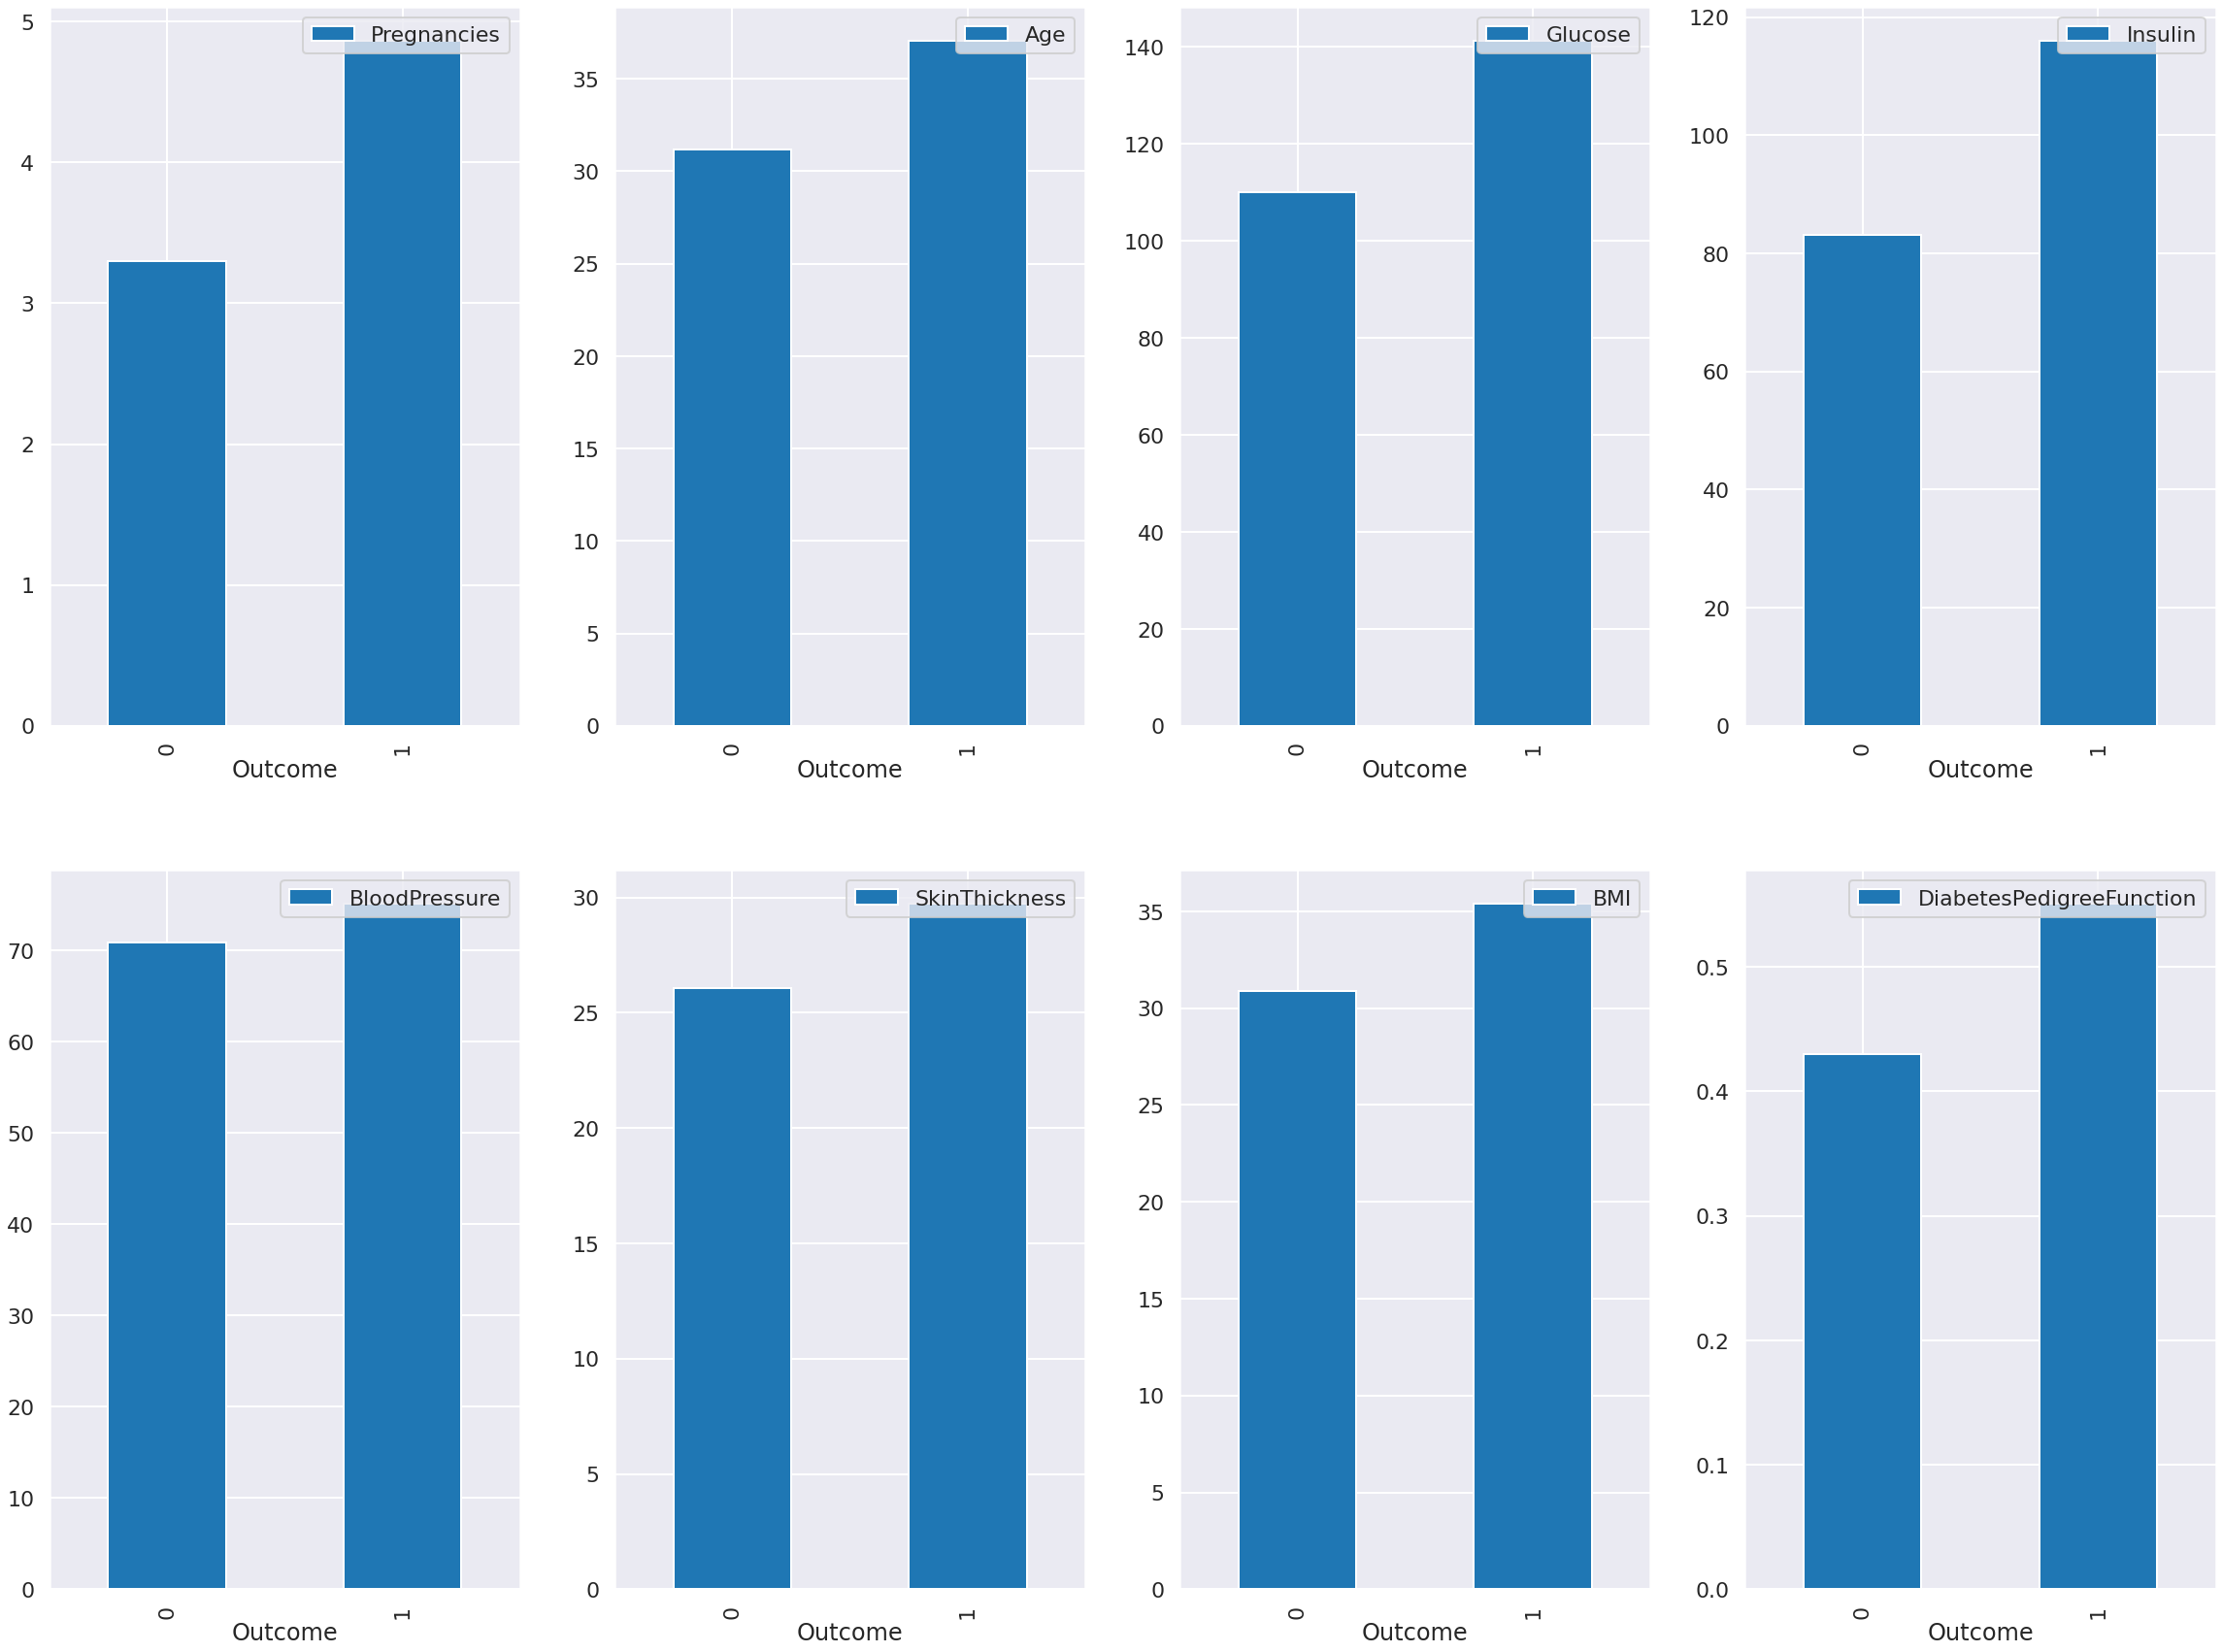

,Pregnancies,Age,Glucose,Insulin,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction
Outcome,,,,,,,,
0,3.298000,31.190000,109.980000,83.188000,70.920000,26.058000,30.880200,0.429734
1,4.865672,37.067164,141.257463,116.041045,75.123134,29.716418,35.381343,0.550500


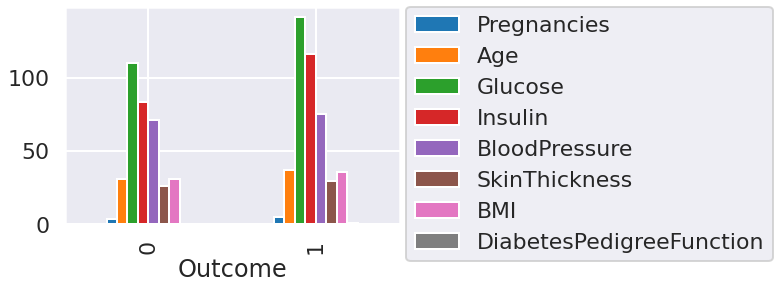

In [7]:
fig, axes = plt.subplots(figsize = (40, 30),nrows = 2, ncols = 4)
plot_these = ["Pregnancies", "Age", "Glucose", "Insulin", "BloodPressure", "SkinThickness", "BMI", "DiabetesPedigreeFunction" ]
for ax, cat in zip(axes.flat,plot_these):
    df.groupby("Outcome")[[cat]].mean().plot(kind="bar", ax = ax)
    ax.legend(loc='upper right')
plt.show()
df.groupby("Outcome")[plot_these].mean().plot(kind="bar")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
df.groupby("Outcome")[plot_these].mean()

# Occurrence of Diabetes compared to glucose and insulin

In this graph, the zero values (missing data) would confuse the viewer in the insulin-axis, so it was replaced with the mean of the sample. We can see a tendency of more positive cases with larger glucose levels, while they are somewhat evenly distributed along the horizontal axis (insulin), so the glucose value has higher importance in predicting the outcome.

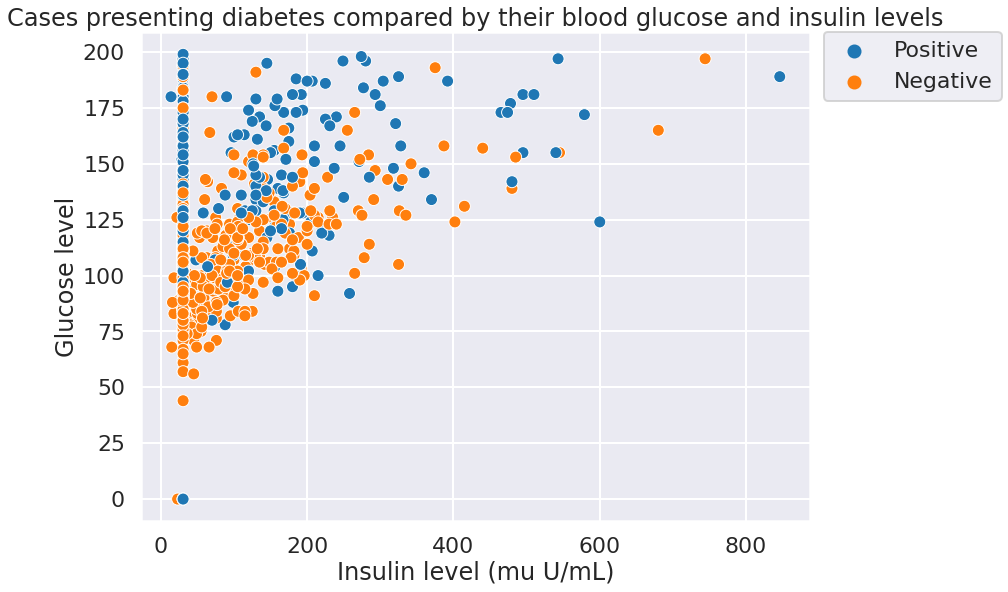

Insulin     Glucose   
(0, 200]    (0, 25]        0
            (25, 50]       0
            (50, 75]       0
            (75, 100]     16
            (100, 125]    66
            (125, 150]    63
            (150, 175]    45
            (175, 200]    30
(200, 400]  (0, 25]        0
            (25, 50]       0
            (50, 75]       0
            (75, 100]      2
            (100, 125]     5
            (125, 150]     7
            (150, 175]     9
            (175, 200]    11
(400, 600]  (0, 25]        0
            (25, 50]       0
            (50, 75]       0
            (75, 100]      0
            (100, 125]     1
            (125, 150]     1
            (150, 175]     5
            (175, 200]     4
(600, 800]  (0, 25]        0
            (25, 50]       0
            (50, 75]       0
            (75, 100]      0
            (100, 125]     0
            (125, 150]     0
            (150, 175]     0
            (175, 200]     0
dtype: int64

In [8]:


df["Test positivity"] = df["Outcome"].replace({1:"Positive", 0:"Negative"})

sns.set_style("darkgrid")
sns.set_context("poster")
plt.figure(figsize=(12, 9))
sns.scatterplot("Insulin", "Glucose", hue=df["Test positivity"], data=df)
plt.title("Cases presenting diabetes compared by their blood glucose and insulin levels")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel("Insulin level (mu U/mL)")
plt.ylabel("Glucose level")
plt.show()
help_df=df[['Outcome','Glucose','Insulin']]
pos_df=help_df.query('Outcome==1')
neg_df=help_df.query('Outcome==0')
Gl_values=[0,25,50,75,100,125,150,175,200]
In_values=[0,200,400,600,800]
pos_df["Insulin"]=pd.cut(pos_df.Insulin, In_values)
pos_df["Glucose"]=pd.cut(pos_df.Glucose, Gl_values)
display(pos_df.groupby(['Insulin', 'Glucose']).size())

# Comparing BMI and Age
From the plot it can be seen as almost all positive case has greater than 25 BMI. Also they occupy the 30-60 range in years, one possible explanation is that people with diabetes have shorter expected lifespan.

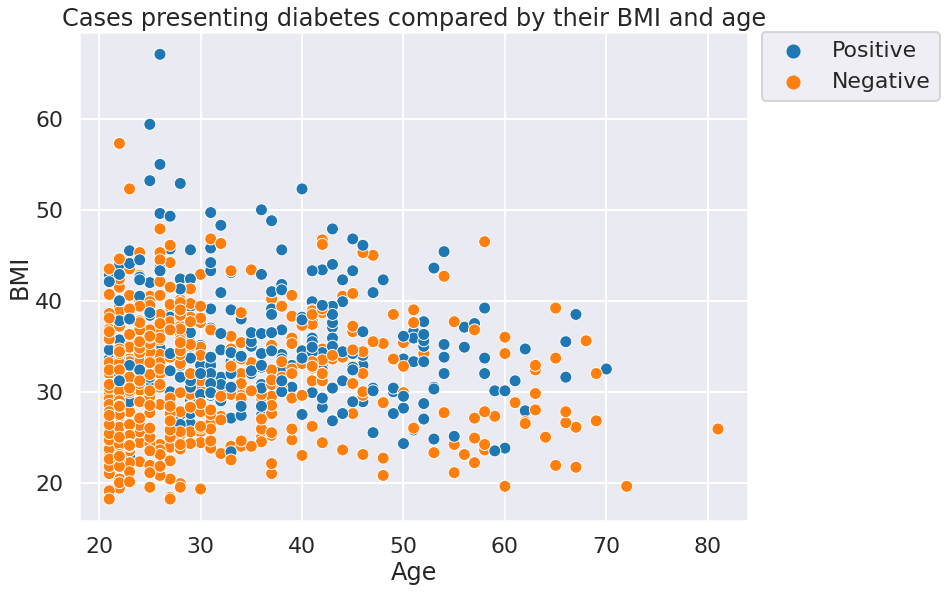

In [9]:
sns.set_style("darkgrid")
sns.set_context("poster")
plt.figure(figsize=(12, 9))
sns.scatterplot("Age", "BMI", hue=df["Test positivity"], data=df)
plt.title("Cases presenting diabetes compared by their BMI and age")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.ylabel("BMI")
plt.xlabel("Age")
plt.show()

# Calculating feature importance for ranges of values

In [10]:
df = pd.read_csv(data_path)
# Define columns with 0 values (NaN) 
null_cols = ["Age", "Insulin","BloodPressure", "SkinThickness", "BMI"]
from sklearn.impute import SimpleImputer
# Fill nulls with the median of the column
median_imputer = SimpleImputer(strategy="median")
for col in null_cols:
    median=df[col].median()
    df=df.replace({col : {0: median}})
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72.0,35.0,30.5,33.6,0.627,50,1
1,1,85,66.0,29.0,30.5,26.6,0.351,31,0
2,8,183,64.0,23.0,30.5,23.3,0.672,32,1
3,1,89,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137,40.0,35.0,168.0,43.1,2.288,33,1


In [11]:
#creating a new dataframe to calculate feature importance
plot_these = ["Pregnancies", "Age", "Glucose", "Insulin", "BloodPressure", "SkinThickness", "BMI", "DiabetesPedigreeFunction" ]
df["Pregnancies"] = pd.cut(df["Pregnancies"], 5, labels=range(0, 5))
df["Age"] = pd.cut(df["Age"], 5, labels=range(0, 5))
df["Glucose"] = pd.cut(df["Glucose"], 5, labels=range(0, 5))
df["Insulin"] = pd.cut(df["Insulin"], 10, labels=range(0, 10))
df["BloodPressure"] = pd.cut(df["BloodPressure"], 5, labels=range(0, 5))
df["SkinThickness"] = pd.cut(df["SkinThickness"], 5, labels=range(0, 5))
df["BMI"] = pd.cut(df["BMI"], 5, labels=range(30, 35))
df[ "DiabetesPedigreeFunction"] = pd.cut(df[ "DiabetesPedigreeFunction" ], 5, labels=range(0, 5))

a = pd.get_dummies(df, columns=plot_these, 
                   prefix=plot_these, drop_first=True)

a.head()

,Outcome,Pregnancies_1,Pregnancies_2,Pregnancies_3,Pregnancies_4,Age_1,Age_2,Age_3,Age_4,Glucose_1,...,SkinThickness_3,SkinThickness_4,BMI_31,BMI_32,BMI_33,BMI_34,DiabetesPedigreeFunction_1,DiabetesPedigreeFunction_2,DiabetesPedigreeFunction_3,DiabetesPedigreeFunction_4
0,1,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


The continuous values are replaced with discrete subcategories, to show the importance of different ranges in the whole domain. The feature importance was calculated by random forest classifier. From this graph it seems that the glucose level, BMI and Skint Thickness have the highest predictive power.

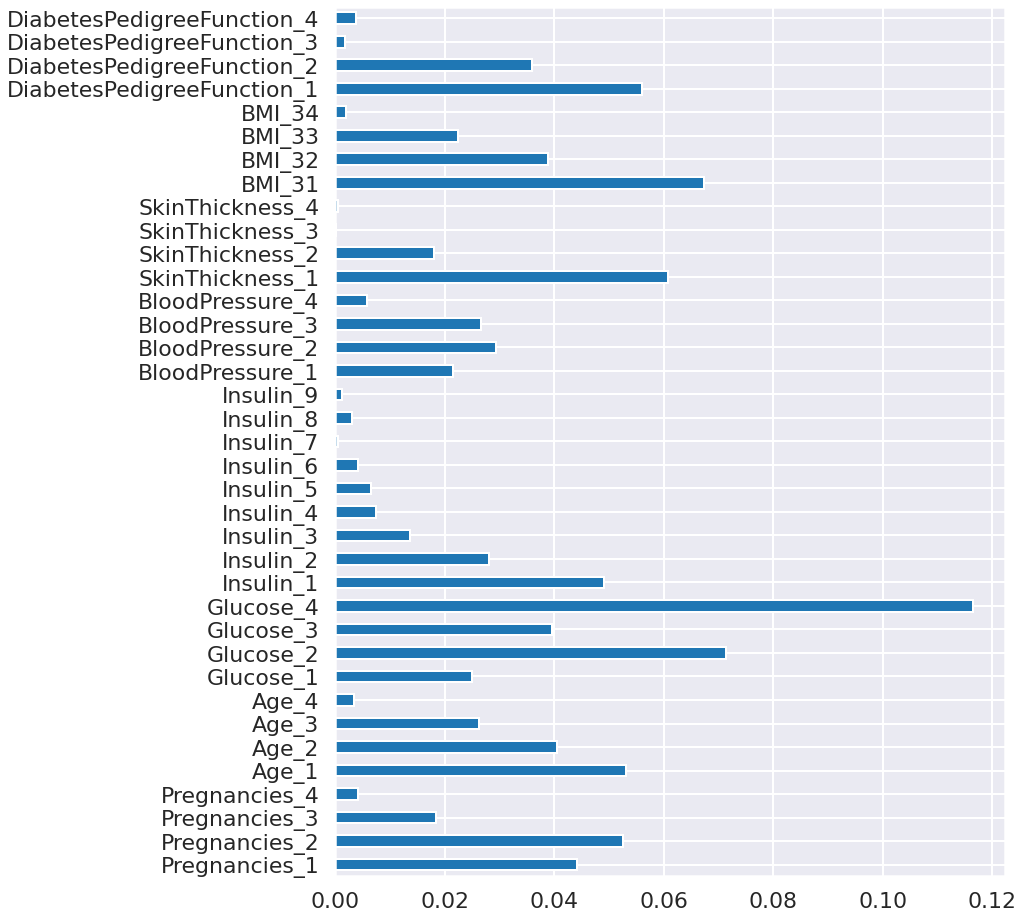

In [12]:
rf = RandomForestClassifier()
rf.fit(a.drop("Outcome", axis=1), a.Outcome)
importances = rf.feature_importances_
features = pd.Series(importances, index=a.drop("Outcome", axis=1).columns)
plt.figure(figsize=(12, 16))
features.plot(kind="barh")
plt.show()

# Creating a machine learning modell

Here we apply XGBoost classifier to Outcome. We also remove the two least significant categories (SkinThickness 3 and 4).

In [17]:
X=a.drop(["Outcome", "SkinThickness_3", "SkinThickness_4"], axis=1)
y = a.Outcome
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#It took forever for Kaggle's kernel to run GridSearchCV with xGBoosting, however I added the results
#of hyperparameter tuning as markdown cells below.

xgb = XGBClassifier(objective="binary:logistic", eval_metric="auc")
params = {"max_depth":np.arange(1, 8), "n_estimators":[100, 300, 500, 600, 900, 1000], 
          "learning_rate":[0.001, 0.01, 0.03, 0.05, 0.07], "colsample_bytree":[0.35, 0.5, 0.65],
          "subsample":[0.4, 0.5, 0.55, 0.7]
         }
grid_xgb = GridSearchCV(estimator = xgb, param_grid = params, cv=10, n_jobs=-1)
grid_xgb.fit(X_train, y_train)
xgb_pred = grid_xgb.predict(X_test)
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.76      0.86      0.81       100
           1       0.66      0.50      0.57        54

    accuracy                           0.73       154
   macro avg       0.71      0.68      0.69       154
weighted avg       0.73      0.73      0.72       154



In [14]:
print(grid_xgb.best_params_)
print('\n')
print(grid_xgb.cv_results_["mean_test_score"].mean())
print('\n')
print(classification_report(y_test, xgb_pred))

{'colsample_bytree': 0.35, 'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'subsample': 0.7}


0.7565109163707788


              precision    recall  f1-score   support

           0       0.76      0.86      0.81       100
           1       0.66      0.50      0.57        54

    accuracy                           0.73       154
   macro avg       0.71      0.68      0.69       154
weighted avg       0.73      0.73      0.72       154



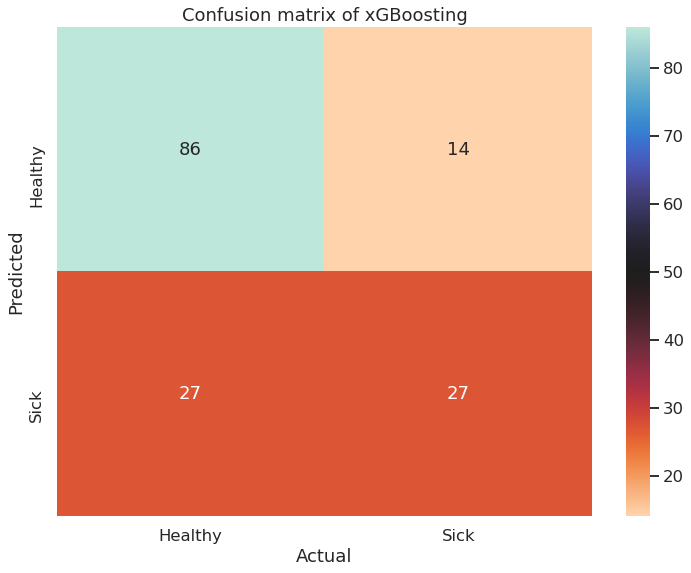

In [15]:
sns.set_context("talk")
plt.figure(figsize=(12, 9))
sns.heatmap(confusion_matrix(y_test, xgb_pred), annot=True, xticklabels=["Healthy", "Sick"], yticklabels=["Healthy", "Sick"], fmt="g", cmap="icefire_r")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.title("Confusion matrix of xGBoosting")
plt.show()

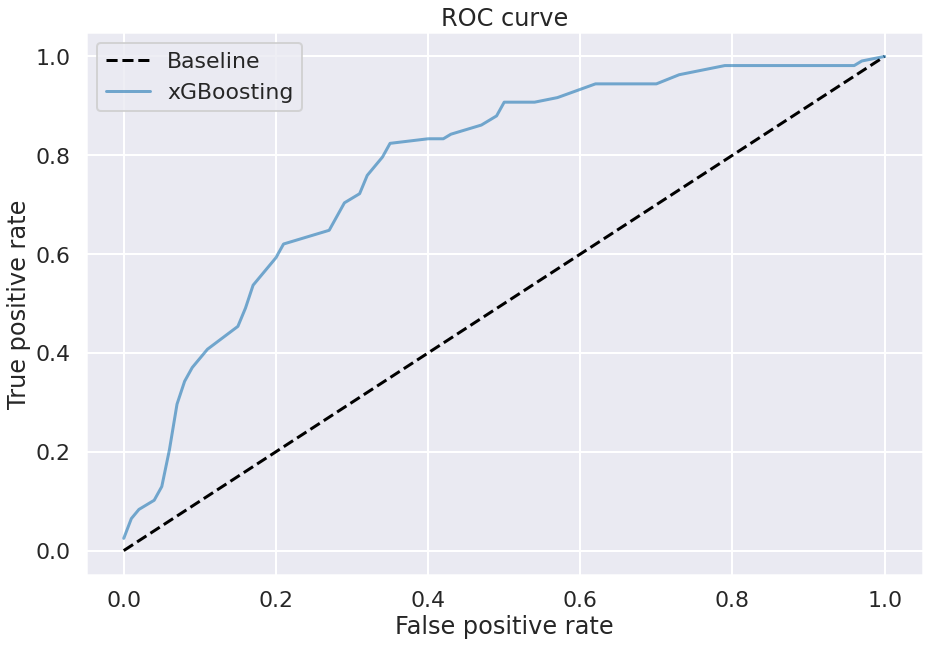

0.7767592592592593


In [18]:


xgb = XGBClassifier(objective="binary:logistic", eval_metric="auc", max_depth=1,
                    n_estimators=500,learning_rate=0.05,colsample_bytree=0.35,subsample=0.5)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)


xgb_prob = xgb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, xgb_prob)
sns.set_style("darkgrid")
sns.set_context("poster")
plt.figure(figsize=(15, 10))
plt.plot([0, 1], [0, 1], 'k--')
sns.lineplot(fpr, tpr, alpha=0.6, ci=None)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(["Baseline", "xGBoosting"])
plt.show()
print(roc_auc_score(y_test, xgb_prob))